# Scrapping

In [25]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import pandas as pd
import re

BASE_URL = "https://www.gob.mx"
PAGE_URL_TEMPLATE = "https://www.gob.mx/presidencia/es/archivo/articulos?page={}"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def clean_url(url):
    """Remove escaped characters and quotes from URL"""
    if not url:
        return None
    # Remove all types of quotes and escape characters
    cleaned = url.replace('\\"', '').replace('"', '').replace('\\/', '/')
    # Remove leading/trailing spaces
    cleaned = cleaned.strip()
    return cleaned

def clean_date(date_str):
    """Extract clean date/time from escaped string.
    Supports formats like 'YYYY-MM-DD HH:MM:SS' or 'YYYY-MM-DDTHH:MM:SS' and optional timezone.
    """
    if not date_str:
        return None
    cleaned = date_str.replace('\\"', '').replace('"', '').replace('\\/', '/')
    cleaned = cleaned.strip()
    # Match full timestamp with space or 'T' and optional timezone (Z or ±HH:MM)
    m = re.search(r"\d{4}-\d{2}-\d{2}[ T]\d{2}:\d{2}:\d{2}(?:Z|[+-]\d{2}:?\d{2})?", cleaned)
    if m:
        return m.group(0)
    # Fallback to date only
    m = re.search(r"\d{4}-\d{2}-\d{2}", cleaned)
    return m.group(0) if m else cleaned

def clean_title(title_str):
    """Extract clean title, removing HTML tags and escape characters"""
    if not title_str:
        return None
    # Remove escape characters and quotes
    cleaned = title_str.replace('\\"', '').replace('"', '').replace('\\/', '/')
    # Remove HTML tags
    cleaned = re.sub(r'<[^>]+>', '', cleaned)
    # Remove common JS patterns
    cleaned = re.sub(r'\\n|\\t', ' ', cleaned)
    cleaned = re.sub(r'Continuar leyendo.*', '', cleaned, flags=re.DOTALL)
    # Strip extra whitespace
    cleaned = ' '.join(cleaned.split())
    return cleaned.strip()

def extract_articles_info_from_html(html):
    soup = BeautifulSoup(html, "html.parser")
    articles = []
    for article in soup.find_all("article"):
        # Link
        a = article.find("a", href=True)
        href = a["href"] if a else None
        link = clean_url(urljoin(BASE_URL, href)) if href else None
        
        # Date - try multiple attribute names and text
        time_tag = article.find("time")
        date_attr = None
        if time_tag:
            # prefer explicit attributes
            for attr in ("date", "datetime"):
                if time_tag.has_attr(attr):
                    date_attr = time_tag.get(attr)
                    break
            if date_attr is None:
                # fallback to text content
                date_attr = time_tag.get_text(" ", strip=True)
        date = clean_date(date_attr) if date_attr else None
        
        # Title
        h2 = article.find("h2")
        # Use inner text of h2; sometimes the content contains extra nodes, so get_text is safer
        title = clean_title(h2.get_text(" ", strip=True)) if h2 else None
        
        articles.append({"link": link, "date": date, "title": title})
    return articles

def get_all_articles_across_pages(max_pages=500, delay=1.0, timeout=15):
    all_articles = []
    seen_pages_without_results = 0
    print("Starting to scrape articles...")
    for page in range(1, max_pages + 1):
        url = PAGE_URL_TEMPLATE.format(page)
        print(f"Scraping page {page}: {url}")
        try:
            resp = requests.get(url, headers=HEADERS, timeout=timeout)
            if resp.status_code == 404:
                print("Page not found (404), stopping.")
                break
            resp.raise_for_status()
            articles = extract_articles_info_from_html(resp.text)
            if not articles:
                seen_pages_without_results += 1
                print(f"No articles found on page {page}.")
                if seen_pages_without_results >= 3:
                    print("No results for 3 pages in a row, stopping.")
                    break
            else:
                seen_pages_without_results = 0
                all_articles.extend(articles)
        except Exception as e:
            print(f"Error scraping page {page}: {e}")
        import time
        time.sleep(delay)
    # Deduplicate by link
    seen = set()
    dedup = []
    for art in all_articles:
        if art["link"] and art["link"] not in seen:
            seen.add(art["link"])
            dedup.append(art)
    return dedup


In [26]:
# Scrape and save to CSV
articles = get_all_articles_across_pages(max_pages=500)
print(f"Total articles scraped: {len(articles)}")
df = pd.DataFrame(articles)
print("\nDataFrame shape:", df.shape)
print("\nFirst 3 rows:")
df.head(3)


Starting to scrape articles...
Scraping page 1: https://www.gob.mx/presidencia/es/archivo/articulos?page=1
Scraping page 2: https://www.gob.mx/presidencia/es/archivo/articulos?page=2
Scraping page 3: https://www.gob.mx/presidencia/es/archivo/articulos?page=3
Scraping page 4: https://www.gob.mx/presidencia/es/archivo/articulos?page=4
Scraping page 5: https://www.gob.mx/presidencia/es/archivo/articulos?page=5
Scraping page 6: https://www.gob.mx/presidencia/es/archivo/articulos?page=6
Scraping page 7: https://www.gob.mx/presidencia/es/archivo/articulos?page=7
Scraping page 8: https://www.gob.mx/presidencia/es/archivo/articulos?page=8
Scraping page 9: https://www.gob.mx/presidencia/es/archivo/articulos?page=9
Scraping page 10: https://www.gob.mx/presidencia/es/archivo/articulos?page=10
Scraping page 11: https://www.gob.mx/presidencia/es/archivo/articulos?page=11
Scraping page 12: https://www.gob.mx/presidencia/es/archivo/articulos?page=12
Scraping page 13: https://www.gob.mx/presidencia/es

,link,date,title
0,https://www.gob.mx//presidencia/es/articulos/v...,2025-11-18,Versión estenográfica. Renovación del Paquete ...
1,https://www.gob.mx//presidencia/es/articulos/v...,2025-11-18,Versión estenográfica. Conferencia de prensa d...
2,https://www.gob.mx//presidencia/es/articulos/v...,2025-11-17,Versión estenográfica. Conferencia de prensa d...


<Axes: title={'center': 'Number of Articles per Week'}, xlabel='date'>

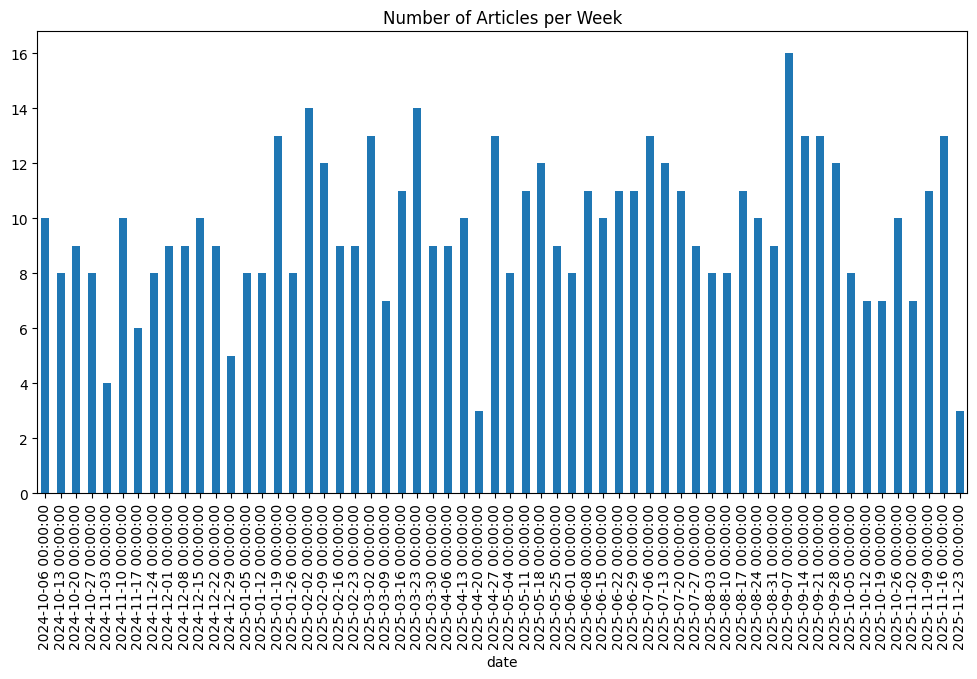

In [31]:
# Histogram of articles per week
df.date = pd.to_datetime(df.date, errors='coerce')
df.set_index('date', inplace=True)
df.resample('W').size().plot(kind='bar', figsize=(12,6), title='Number of Articles per Week')

In [28]:
# Save to CSV
csv_filename = "gobmx_presidencia_articles.csv"
df.to_csv(csv_filename, index=False)
print(f"\nData saved to {csv_filename}")


Data saved to gobmx_presidencia_articles.csv
